In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import os
from google.colab.patches import cv2_imshow
#----------------input image read----------------------
path='/content/drive/My Drive/Images_ml'
files=[]
for r,d,f in os.walk(path):
  for file in sorted(f):
    if '(1).bmp' not in file:
      files.append((os.path.join(r,file)))

image0=cv2.imread(files[0])
#------------------output image read--------------------
path_op='/content/drive/My Drive/BakSubGroundTruth-20200608T150042Z-001/BakSubGroundTruth'
files_op=[]
for r,d,f in os.walk(path_op):
  for file in sorted(f):
    if '(1).bmp' not in file:
      files_op.append((os.path.join(r,file)))
print(len(files_op),len(files))

501 501


In [11]:
from sklearn.metrics import confusion_matrix
#-------------------------functions-------------------------
def kronecker_delta(val):
  if val==0:
    result=1
  else:
    result=0
  return result

def fm(a):
  b=np.zeros((a.shape[0],2))
  result = np.column_stack((b,a))
  result = np.column_stack((result,b))

  row=np.zeros((2,a.shape[1]+4))
  result1 = np.vstack((result,row))
  results=np.vstack((row,result1))
  countM=np.zeros(a.shape)
  for row in range(0,results.shape[0]-4):
    for col in range(0,results.shape[1]-4):
      window=results[row:row+5,col:col+5]
      count=np.count_nonzero(window == 255)
      countM[row,col]=count
  return countM

def alpha(t):
  if t>100:
    ret= .01
  else:
    ret=(1/(t+1))
  return ret



list=[.5, 1, 2, 3, 4, 5, 6, 7]
tpr=np.zeros(8)
fpr=np.zeros(8)
j=0
for lamda in list:
  
  pred_matrix=np.zeros((288*360,500))
  test_matrix=np.zeros((288*360,500))
  image0=cv2.imread(files[0])
  vold=np.ones(image0.shape)
  vnew=np.zeros(image0.shape)
  vold=vold*9

  Mold=np.zeros(image0.shape)
  Mold=image0
  Mnew=np.zeros(image0.shape)
  for i in range(1,501):

    image1=cv2.imread(files[i])
    I=image1
    D=np.zeros(image0.shape)
    D=I-Mold
    Dsq=D**2
    #-------lamda-----------

    c=np.zeros((image0.shape[0],image0.shape[1]))
    vc=np.zeros((image0.shape[0],image0.shape[1]))

    #--------foreground detection----------------

    for row in range(image0.shape[0]):
      for col in range(image0.shape[1]):
        if Dsq[row,col,0]<=(lamda**2)*vold[row,col,0] and Dsq[row,col,1]<=(lamda**2)*vold[row,col,1] and Dsq[row,col,2]<=(lamda**2)*vold[row,col,2]:
          c[row,col]=0
        else:
          c[row,col]=255
    countM=fm(c)    
    for row in range(image0.shape[0]):
      for col in range(image0.shape[1]):

        
        #-----------noise removal--------------
        m=5
        nv=.6
        if countM[row,col]/(m*m)>=nv:
          vc[row,col]=255
        else:
          vc[row,col]=0

        #------------model update---------------
        alpha_t=alpha(i)
        
        Mnew[row,col,:]=Mold[row,col,:]+kronecker_delta(vc[row,col])*alpha_t*D[row,col,:]
        
        vnew[row,col,:]= kronecker_delta(vc[row,col]-255)*(vold[row,col,:]) + kronecker_delta(vc[row,col])*((1-alpha_t)*(vold[row,col,:]+alpha_t*Dsq[row,col,:]))
    vold=vnew
    Mold=Mnew
    #cv2_imshow(vnew)
    vc_flat=vc.flatten()
    pred_matrix[:,i-1]=vc_flat

    op_image=cv2.imread(files_op[i])
    gray = cv2.cvtColor(op_image, cv2.COLOR_BGR2GRAY)
    gray_flat=gray.flatten()
    test_matrix[:,i-1]=gray_flat
  test_flat=test_matrix.flatten()
  pred_flat=pred_matrix.flatten()
  test=test_flat/255
  pred=pred_flat/255
  print("-----------------------------------------------------")
  print("value of lamda: ",lamda)
  mat=confusion_matrix(test,pred,labels=[0,1])
  tpr[j]=mat[1,1]/(mat[1,1]+mat[1,0])
  fpr[j]=mat[0,1]/(mat[0,1]+mat[0,0])
  print("sensitivity:  ",tpr[j],"\n","false positive rate:  ",fpr[j])
  j=j+1

-----------------------------------------------------
value of lamda:  0.5
sensitivity:   0.9971681657908606 
 false positive rate:   0.9636855183910698
-----------------------------------------------------
value of lamda:  1
sensitivity:   0.9912425273491853 
 false positive rate:   0.41159919806449397
-----------------------------------------------------
value of lamda:  2
sensitivity:   0.8530577502772957 
 false positive rate:   0.008410418141566811
-----------------------------------------------------
value of lamda:  3
sensitivity:   0.7088260523454917 
 false positive rate:   0.002907233063288131
-----------------------------------------------------
value of lamda:  4
sensitivity:   0.38235010044389367 
 false positive rate:   0.0011178965623424974
-----------------------------------------------------
value of lamda:  5
sensitivity:   0.09005373913695432 
 false positive rate:   0.0005472583474347151
-----------------------------------------------------
value of lamda:  6
sensit

In [25]:
print("values of sensitivity and false positive rates for all lamdas:")
print("sensitivity: \n",tpr,"\n","false positive rate: \n",fpr)

values of sensitivity and false positive rates for all lamdas:
sensitivity: 
 [0.99716817 0.99124253 0.85305775 0.70882605 0.3823501  0.09005374
 0.02519808 0.01093085] 
 false positive rate: 
 [9.63685518e-01 4.11599198e-01 8.41041814e-03 2.90723306e-03
 1.11789656e-03 5.47258347e-04 4.32053496e-04 4.02319307e-04]


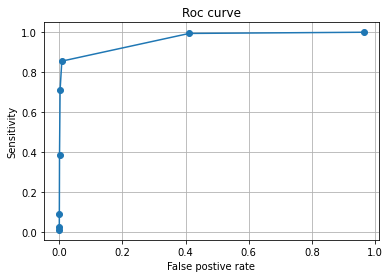

In [26]:
plt.plot(fpr,tpr,"-o")
plt.title("Roc curve")
plt.xlabel("False postive rate")
plt.ylabel("Sensitivity")
plt.grid()
plt.show()